<a href="https://colab.research.google.com/github/Sunnn-y/ICR_Project/blob/main/jobplanet_labeling_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# concat한 잡플래닛 리뷰 파일 불러오기
df_raw = pd.read_csv('/content/drive/MyDrive/ICR_project/잡플래닛_크롤링/jobplanet_concat.csv')
df_raw.head(1)

,작성일,직무,재직 여부,지역,총점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,바라는점
0,2023. 11,엔지니어링,전직원,대전,80,80,80,60,80,80,업무환경은 힘들지만 만족도가 높으며 페이가 좋음,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,현장에서 하는 일이다보니 몸이 힘들고 삶의 여유가 없음,더 좋은 회사로 성장하길 바라겠습니다


In [ ]:
# 행과 열 개수 확인
df_raw.shape

(4422, 14)

In [ ]:
# 칼럼명 확인
df_raw.columns

Index(['작성일', '직무', '재직 여부', '지역', '총점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형',
       '사내문화', '경영진', '총평', '장점', '단점', '바라는점'],
      dtype='object')

# 키워드 추출

## 전처리

In [ ]:
# 데이터 손실을 방지하기 위해 복사
df = df_raw.copy()

In [ ]:
df_merit_demerit = df.drop(columns=['작성일', '직무', '재직 여부', '지역', '총점', '승진 기회 및 가능성',
                                    '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진', '총평', '바라는점'])
df_merit_demerit.head(1)

,장점,단점
0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,현장에서 하는 일이다보니 몸이 힘들고 삶의 여유가 없음


In [ ]:
df_merit = df.drop(columns=['작성일', '직무', '재직 여부', '지역', '총점', '승진 기회 및 가능성','복지 및 급여',
                            '업무와 삶의 균형', '사내문화', '경영진', '총평', '단점', '바라는점'])
df_merit.head(1)

,장점
0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음


In [ ]:
df_demerit = df.drop(columns=['작성일', '직무', '재직 여부', '지역', '총점', '승진 기회 및 가능성','복지 및 급여',
                            '업무와 삶의 균형', '사내문화', '경영진', '총평', '장점', '바라는점'])
df_demerit.head(1)

,단점
0,현장에서 하는 일이다보니 몸이 힘들고 삶의 여유가 없음


In [ ]:
# 장단점을 담은 리스트를 만들자!
# 빈 리스트 생성
merit_demerit = []

# "장점" 칼럼의 각 행을 리스트에 추가
for index, row in df_merit_demerit.iterrows():
    merit_demerit.append(row['장점'])

# "단점" 칼럼의 각 행을 리스트에 추가
for index, row in df_merit_demerit.iterrows():
    merit_demerit.append(row['단점'])

# 결과 출력
len(merit_demerit)

8844

In [ ]:
# !pip install konlpy

In [ ]:
from konlpy.tag import Okt
import re

# 문장에서 명사만 추출하는 함수
def split_noun_sentences(text_list):
    okt = Okt()
    result = []

    for text in text_list:
        sentences = text.replace(". ","")
        sentences = text.replace(".","")
        sentences = re.sub(r'([^\n\s\.\?!]+[^\n\.\?!]*[\.\?!])', r'\1\n', sentences).strip().split("\n")

        for sentence in sentences:
            if len(sentence) == 0:
                continue
            sentence_pos = okt.pos(sentence, stem=True)
            nouns = [word for word, pos in sentence_pos if pos == 'Noun']
            if len(nouns) <= 2:
                continue
            result.append(' '.join(nouns) + '.')

    return result

In [ ]:
# # 장단점에서 명사만 추출
# merit_demerit_nouns = split_noun_sentences(merit_demerit)

## LDA
LDA를 통해 장단점 문장에서 어떤 토픽이 추출되는지 알아본다.

In [ ]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel

# 분석할 문서를 공백으로 토큰화
tokenized_nouns = []
for doc in merit_demerit_nouns:
  tokenized_nouns.append(doc.split(' '))
tokenized_nouns

[['업무', '강도', '강하', '급여', '수.'],
 ['지역', '몇', '중견', '기업', '중', '하나', '신입', '연봉', '연봉.'],
 ['연차', '사용', '가능', '함', '다만', '현장', '때', '사용', '불가', '팀', '조율', '함', '것.'],
 ['제공', '중식', '식비', '절약', '휴식시간', '문서', '보조', '작업', '업무', '난이도.'],
 ['대전', '연봉', '편이', '점심', '음.'],
 ['월급', '식권', '귀향', '여비', '정산', '월', '하부', '직급', '사람', '것.'],
 ['장점', '음', '직원', '이야기.'],
 ['연차', '사용', '대해', '크게', '말', '편임', '경험', '수', '직시', '도움.'],
 ['보수', '성향', '경기', '때', '안정', '방향', '결정', '지방', '건설', '사라', '지역', '성향.'],
 ['부바',
  '부',
  '바',
  '연차',
  '눈치',
  '안보',
  '장식',
  '지원',
  '방식',
  '개편',
  '좀',
  '더',
  '사람',
  '답',
  '생활',
  '일',
  '동료.'],
 ['연차',
  '사용',
  '복지',
  '근무',
  '환경',
  '양호',
  '회사',
  '장래',
  '발전',
  '가능성',
  '기업',
  '문화',
  '양호',
  '회사',
  '양호',
  '실적',
  '구조.'],
 ['나름', '대전', '연봉', '상위', '돈', '함', '구내식당', '탄방역', '바로', '앞', '교통', '나름.'],
 ['낭만',
  '편',
  '구성원',
  '전체',
  '노력',
  '회사',
  '고용',
  '안정',
  '보수',
  '향토',
  '기업',
  '존재',
  '감',
  '채용',
  '진심',
  '임.'],
 ['일단', '저년', '차', '입장', '돈', '대

In [ ]:
id2word = corpora.Dictionary(tokenized_docs)
print(id2word)

Dictionary<4963 unique tokens: ['기업', '몇', '신입', '연봉', '연봉.']...>


In [ ]:
for value in id2word:
  print(value, id2word[value])

0 기업
1 몇
2 신입
3 연봉
4 연봉.
5 중
6 중견
7 지역
8 하나
9 가능
10 것.
11 다만
12 때
13 불가
14 사용
15 연차
16 조율
17 팀
18 함
19 현장
20 난이도.
21 문서
22 보조
23 식비
24 업무
25 작업
26 절약
27 제공
28 중식
29 휴식시간
30 대전
31 편이.
32 귀향
33 식권
34 여비
35 월.
36 월급
37 정산
38 사람
39 직급
40 하부
41 음
42 이야기.
43 장점
44 직원
45 경험
46 대해
47 도움.
48 말
49 수
50 직시
51 크게
52 편임
53 보수
54 성향.
55 결정.
56 경기
57 방향
58 안정
59 건설
60 사라
61 지방
62 개편
63 눈치
64 답
65 더
66 동료.
67 바
68 방식
69 부
70 부바
71 생활
72 안보
73 일
74 장식
75 좀
76 지원
77 가능성
78 구조.
79 근무
80 문화
81 발전
82 복지
83 실적
84 양호
85 장래
86 환경
87 회사
88 교통
89 구내식당
90 나름
91 나름.
92 돈
93 바로
94 상위
95 앞
96 탄방역
97 감
98 고용
99 구성원
100 낭만
101 노력
102 임.
103 전체
104 존재
105 진심
106 채용
107 편
108 향토
109 일단
110 입장
111 저년
112 차
113 회사.
114 배치
115 줌
116 첫
117 최대한
118 편의
119 그
120 비교
121 외
122 운.
123 값
124 군중
125 서희
126 이
127 이름
128 일지.
129 정도
130 가족
131 다소
132 분위기.
133 특유
134 것
135 눈듯.
136 공기
137 끼
138 맑음.
139 시세
140 적지
141 페이
142 노사
143 멀티
144 사관학교
145 수.
146 역할
147 플레어
148 급여
149 로움
150 시공사
151 자유
152 타
153 편.
154 니.
155 람둘
156 선호
157 애
158

In [ ]:
# corpus_TDM = [id2word.doc2bow(doc) for doc in tokenized_docs]
corpus_TDM = []
for doc in tokenized_docs:
  # print(doc)
  result = id2word.doc2bow(doc)
  # print(result) ## index, 등장 횟수(순서는 index순으로 sorting 해서 출력됨)
  # print('\n')
  corpus_TDM.append(result)

corpus_TDM

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(3, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)],
 [(10, 1), (38, 1), (39, 1), (40, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(3, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)],
 [(10, 1), (38, 1), (39, 1), (40, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 

In [ ]:
tfidf = TfidfModel(corpus_TDM)
corpus_TFIDF = tfidf[corpus_TDM]

n = 10   # 토픽 개수 - 변경 가능
lda = LdaModel(corpus = corpus_TFIDF,
               id2word = id2word,
               num_topics = n,
               random_state = 100)

for t in lda.print_topics():
  print(t[0], ":", t[1])

0 : 0.008*"라벨." + 0.008*"연차" + 0.007*"돈" + 0.007*"점심" + 0.007*"아침" + 0.006*"눈치." + 0.006*"정말" + 0.006*"저녁" + 0.005*"식사" + 0.005*"구내식당"
1 : 0.011*"분위기." + 0.010*"현장" + 0.010*"연차" + 0.007*"눈치" + 0.007*"대기업" + 0.007*"근무" + 0.006*"사용" + 0.006*"야근" + 0.006*"사람" + 0.006*"연봉"
2 : 0.010*"월급" + 0.008*"편이." + 0.007*"연차" + 0.006*"연봉." + 0.006*"기간" + 0.006*"칼" + 0.005*"연봉" + 0.005*"업무." + 0.005*"밥" + 0.005*"부문"
3 : 0.008*"업무" + 0.007*"강도." + 0.006*"순환" + 0.006*"워" + 0.006*"분위기." + 0.006*"공기업" + 0.006*"밸." + 0.006*"이기" + 0.006*"근무" + 0.006*"예전"
4 : 0.010*"연차" + 0.010*"사용" + 0.009*"눈치" + 0.009*"가능." + 0.006*"복지" + 0.006*"안보" + 0.006*"직도" + 0.005*"카드" + 0.005*"현장" + 0.005*"탑"
5 : 0.008*"자유" + 0.008*"현장" + 0.008*"직원" + 0.007*"연차" + 0.007*"사용" + 0.006*"복지" + 0.006*"사람" + 0.006*"일" + 0.005*"준수" + 0.005*"급여"
6 : 0.008*"회사" + 0.008*"직" + 0.008*"본사" + 0.008*"지원" + 0.007*"계약" + 0.007*"정규직" + 0.007*"연봉" + 0.006*"근무" + 0.006*"대기업" + 0.006*"임"
7 : 0.010*"일" + 0.010*"공기업" + 0.009*"대기업" + 0.009*"복지" + 0.009*"장점"

## KR WordRank

In [ ]:
unique_words = list(set(word for text in merit_demerit_nouns for word in text.split()))
len(unique_words)

8512

In [ ]:
from krwordrank.word import KRWordRank

min_count = 1   # 단어의 최소 출현 빈도수 (그래프 생성 시)
max_length = 10 # 단어의 최대 길이
wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)
beta = 0.85    # PageRank의 decaying factor beta
max_iter = 20
texts = split_noun_sentences(merit_demerit_nouns)
keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)

for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True):
  print('%8s:\t%.4f' % (word, r))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
      장소:	0.9034
      현이:	0.9007
     따라서:	0.8995
      연고:	0.8983
      은행:	0.8971
      주먹:	0.8963
      방법:	0.8949
      외적:	0.8938
      끈끈:	0.8930
      정리:	0.8878
      각자:	0.8870
      대다:	0.8866
      막내:	0.8860
      남아:	0.8852
      별도:	0.8817
      데이:	0.8806
      집단:	0.8804
      기타:	0.8800
      세대:	0.8760
      축소:	0.8753
      편입:	0.8750
      추세:	0.8749
      뭔가:	0.8735
      떡값:	0.8713
      악화:	0.8697
      선호:	0.8690
      권장:	0.8684
      안해:	0.8681
      한수:	0.8666
      완전:	0.8665
      지연:	0.8642
      마이:	0.8613
      밥값:	0.8598
      비합:	0.8582
      부담:	0.8579
      전산:	0.8572
      강압:	0.8571
      소마:	0.8568
      그게:	0.8560
      초과:	0.8560
      기반:	0.8557
      연령:	0.8555
      우선:	0.8543
      나머:	0.8537
      습득:	0.8506
      공채:	0.8500
      탈출:	0.8493
      경상:	0.8485
      집중:	0.8484
      대학:	0.8450
      속도:	0.8442
      판단:	0.8423
      굳이:	0.8420
      패딩:	0.8398
      술자:	0.8383
      이탈:	0.8376
      기도:	0.

In [ ]:
# !pip install wordcloud
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

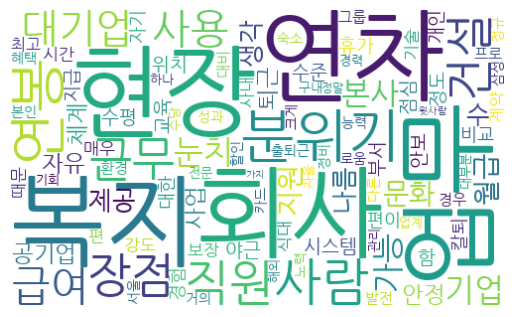

In [ ]:
from wordcloud.wordcloud import FONT_PATH
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

text = " ".join(keywords)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color= 'white',
    relative_scaling=.5,
    width = 500,
    height = 300,
    font_path=FONT_PATH).generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word2Vec

In [ ]:
# !pip install word2vec

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized_nouns, min_count=1)

similar_words = model.wv.most_similar('임금', topn=100)
print(similar_words)

In [ ]:
df_merit_demerit[df_merit_demerit['장점'].str.contains('승진')]

In [ ]:
merit_demerit_nouns

# 라벨링

## 장점 라벨링

In [ ]:
aspect_term = '2세경영 | 가족경영 | 가족회사 | 갑질 | 경영인 | 경영진 | 고인물 | 노동력 | 노예 | 대표 | 도구 | 리더 | 머슴 | 무능 | 방만 경영 | 부장 | 비전 | 사장 | 상급자 | 상사 | 소모품 | 소장 | 역피라미드 | 오너 | 임원 | 임직원 | 직원 | 전문경영 | 퇴보 | 팀장 | 현장의 소리 | 회장'

In [ ]:
df_merit.loc[df_merit['장점'].str.contains(aspect_term), '감정'] = '긍정'
df_merit.loc[~df_merit['장점'].str.contains(aspect_term), '감정'] = '중립'
df_merit.head()

,장점,감정
0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,중립
1,대전지역에 몇 없는 중견기업 중 하나 신입연봉치곤 괜찮은 연봉,중립
2,연차 자유롭게 사용 가능 함 다만 현장이 바쁠때는 사용 불가 팀장이랑 조율 해야함 ...,중립
3,제공되는 중식으로 식비를 절약할수있음 자유로운 휴식시간과 단순한 문서보조 작업만 해...,중립
4,1대전에서 연봉이 높은편이다. 2점심을 준다. 3음,중립


In [ ]:
# 칼럼명 변경(장점 > 문장)
df_merit.rename(columns={'장점':'문장'},inplace=True)
df_merit.head()

,문장,감정
0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,중립
1,대전지역에 몇 없는 중견기업 중 하나 신입연봉치곤 괜찮은 연봉,중립
2,연차 자유롭게 사용 가능 함 다만 현장이 바쁠때는 사용 불가 팀장이랑 조율 해야함 ...,중립
3,제공되는 중식으로 식비를 절약할수있음 자유로운 휴식시간과 단순한 문서보조 작업만 해...,중립
4,1대전에서 연봉이 높은편이다. 2점심을 준다. 3음,중립


## 단점 라벨링

In [ ]:
df_demerit.loc[df_demerit['단점'].str.contains(aspect_term), '감정'] = '부정'
df_demerit.loc[~df_demerit['단점'].str.contains(aspect_term), '감정'] = '중립'
df_demerit.head()

,단점,감정
0,현장에서 하는 일이다보니 몸이 힘들고 삶의 여유가 없음,중립
1,수직구조가 절대적인 회사 결국 괜찮고 일 잘하는 사람은 다 나가는 현실,중립
2,복지제도 좋은게 없음 사원 대리 6퇴근 다른 사람들 그전에 사라짐,중립
3,근무지로 가는 대중교통이 적다 자차가 있어야 출퇴근이 편하다,중립
4,1복지라 할게 없다. 2근무시간이 길다. 3야근을 많이 한다. 4임원들이 힘들게 한다,중립


In [ ]:
# 칼럼명 변경(단점 > 문장)
df_demerit.rename(columns={'단점':'문장'},inplace=True)
df_demerit.head(1)

,문장,감정
0,현장에서 하는 일이다보니 몸이 힘들고 삶의 여유가 없음,중립


In [ ]:
# 장점과 단점 concat
df_labeled = pd.concat([df_merit, df_demerit], ignore_index=True)

In [ ]:
df_labeled['감정'].value_counts()

중립    8546
부정     217
긍정      81
Name: 감정, dtype: int64

In [ ]:
# 감정 결측치 삭제
df_labeled = df_labeled.dropna(subset=['감정'])
len(df_labeled)

8844

In [ ]:
df_labeled.to_csv('jobplanet_labeled_경영진.csv', encoding='utf-8-sig')

# Concat

In [ ]:
file_paths = ['/content/drive/MyDrive/ICR_project/잡플래닛_라벨링/jobplanet_labeled_경영진.csv',
              '/content/drive/MyDrive/ICR_project/잡플래닛_라벨링/jobplanet_labeled_발전가능성.csv',
              '/content/drive/MyDrive/ICR_project/잡플래닛_라벨링/jobplanet_labeled_복지및급여.csv',
              '/content/drive/MyDrive/ICR_project/잡플래닛_라벨링/jobplanet_labeled_사내문화.csv',
              '/content/drive/MyDrive/ICR_project/잡플래닛_라벨링/jobplanet_labeled_워라밸.csv']

In [ ]:
# CSV 파일을 담을 빈 리스트 생성
dataframes = []

# 각 파일 경로에 대해 파일을 읽어 데이터프레임으로 리스트에 추가
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        dataframes.append(df)
    except UnicodeDecodeError:
        print(f"Unable to read file with detected encoding: {file_path}")

# 데이터프레임들을 행 방향으로 연결
df = pd.concat(dataframes, axis=0, ignore_index=True)

# 결과 확인
df.head()

,Unnamed: 0,문장,감정
0,0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,중립
1,1,대전지역에 몇 없는 중견기업 중 하나 신입연봉치곤 괜찮은 연봉,중립
2,2,연차 자유롭게 사용 가능 함 다만 현장이 바쁠때는 사용 불가 팀장이랑 조율 해야함 ...,중립
3,3,제공되는 중식으로 식비를 절약할수있음 자유로운 휴식시간과 단순한 문서보조 작업만 해...,중립
4,4,1대전에서 연봉이 높은편이다. 2점심을 준다. 3음,중립


In [ ]:
# 데이터프레임 칼럼 확인
df.columns

Index(['Unnamed: 0', '문장', '감정'], dtype='object')

In [ ]:
# 필요 없는 칼럼(Unnamed: 0) 제거
df = df.drop(columns=['Unnamed: 0'])
df.head(1)

,문장,감정
0,업무강도가 강하지만 그만큼 높은 급여를 기대할 수 있음,중립


In [ ]:
# csv 파일로 저장
df.to_csv('jobplanet_labeled_concat.csv', encoding = 'utf-8-sig', index=False)